# Exoplanet Hunter
**Data source: https://www.kaggle.com/keplersmachines/kepler-labelled-time-series-data**
* Column 1 is the LABEL vector
    * '2' is an exoplanet star
    * '1' is a non-exoplanet-star
* Columns 2 through 3198 are the flux values over time

Import modules

In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

Customize plotting theme

In [14]:
custom_style = {'axes.axisbelow': True,
                'axes.edgecolor': 'white',
                'axes.facecolor': '#3C4053',
                'axes.facecolor':'#3C4053',
                'figure.facecolor':'#3C4053',
                'axes.grid': True,
                'axes.labelcolor': 'grey',
                'axes.linewidth': 0,
                'grid.color': 'grey',
                'grid.linestyle': '-',
                'image.cmap': 'Greys',
                'legend.frameon': False,
                'legend.numpoints': 1,
                'legend.scatterpoints': 1,
                'lines.solid_capstyle': 'round',
                'pdf.fonttype': 42,
                'text.color': 'white',
                'xtick.color': 'white',
                'xtick.direction': 'out',
                'xtick.major.size': 0,
                'xtick.minor.size': 0,
                'ytick.color': 'white',
                'ytick.direction': 'out',
                'ytick.major.size': 0,
                'ytick.minor.size': 0}

sns.set(font_scale=1.7, style='darkgrid', rc=custom_style)

Import data

In [3]:
train1 = pd.read_csv('train_1.csv')

Let's examine the stars with exoplanets

In [17]:
exo1 = train1[train1.LABEL == 2].drop(['Unnamed: 0', 'LABEL'], axis=1)
exo1.head()

,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,FLUX.10,...,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
0,93.85,83.81,20.10,-26.98,-39.56,-124.71,-135.18,-96.27,-79.89,-160.17,...,-78.07,-102.15,-102.15,25.13,48.57,92.54,39.32,61.42,5.08,-39.54
1,-38.88,-33.83,-58.54,-40.09,-79.31,-72.81,-86.55,-85.33,-83.97,-73.38,...,-3.28,-32.21,-32.21,-24.89,-4.86,0.76,-11.70,6.46,16.00,19.93
2,532.64,535.92,513.73,496.92,456.45,466.00,464.50,486.39,436.56,484.39,...,-71.69,13.31,13.31,-29.89,-20.88,5.06,-11.80,-28.91,-70.02,-96.67
3,326.52,347.39,302.35,298.13,317.74,312.70,322.33,311.31,312.42,323.33,...,5.71,-3.73,-3.73,30.05,20.03,-12.67,-8.77,-17.31,-17.35,13.98
4,-1107.21,-1112.59,-1118.95,-1095.10,-1057.55,-1034.48,-998.34,-1022.71,-989.57,-970.88,...,-594.37,-401.66,-401.66,-357.24,-443.76,-438.54,-399.71,-384.65,-411.79,-510.54


Plots each star's light flux over time

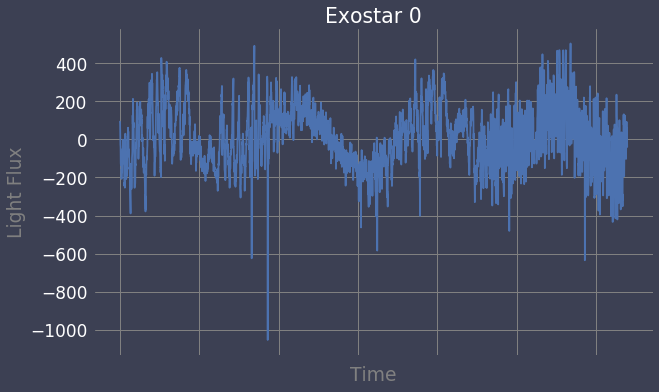

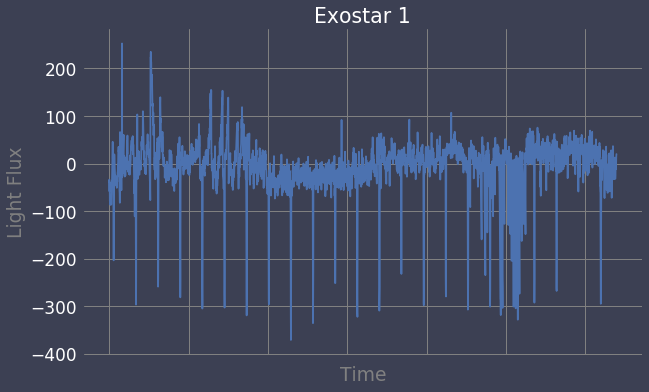

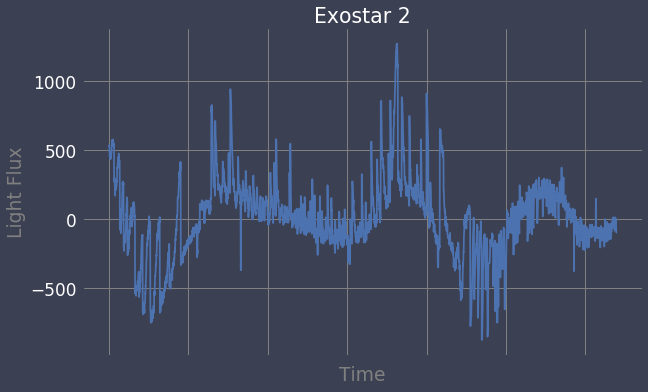

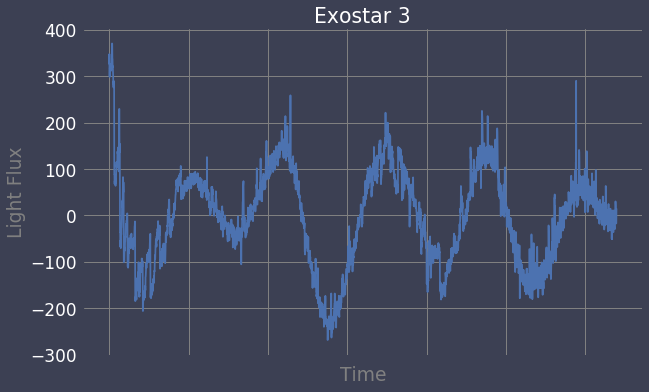

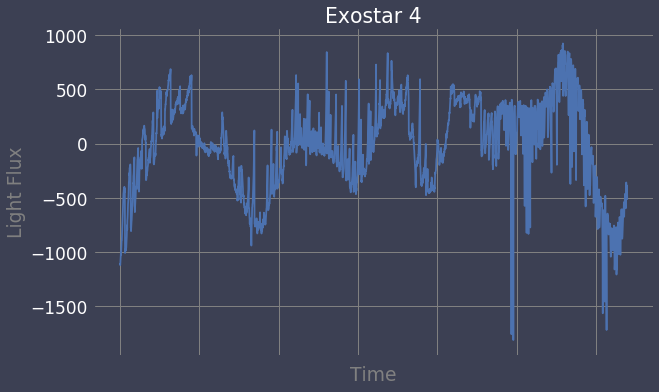

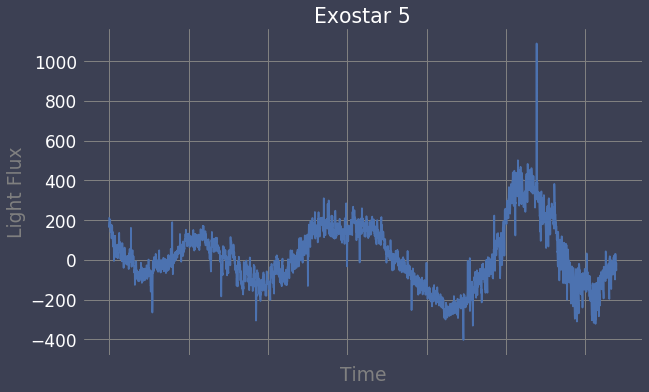

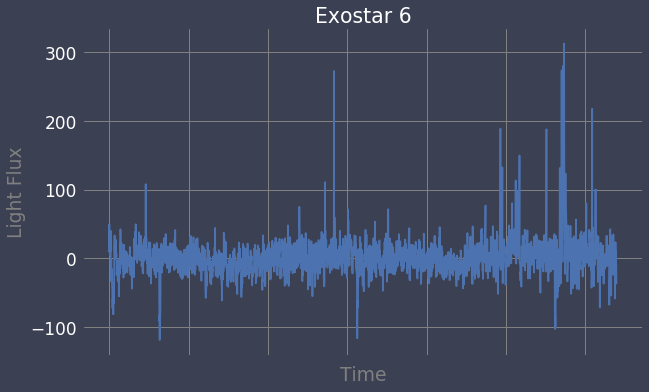

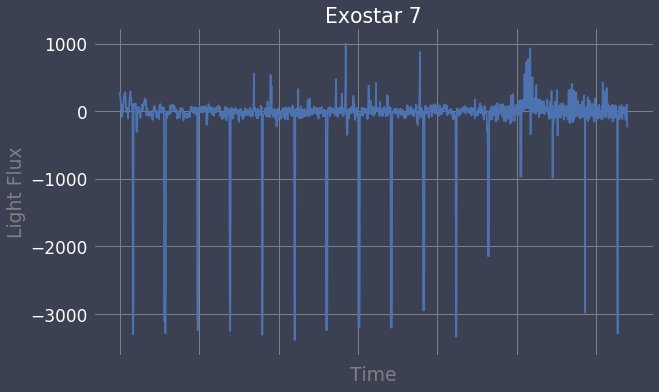

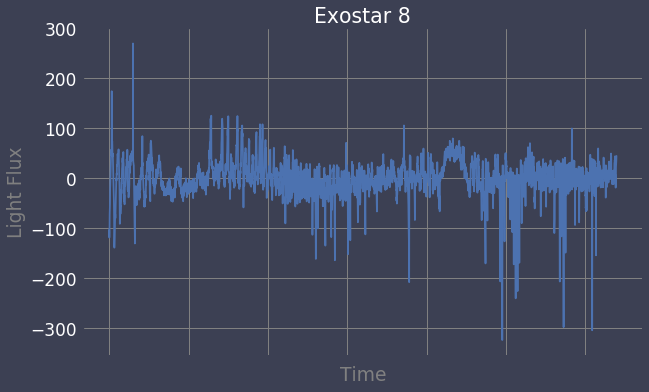

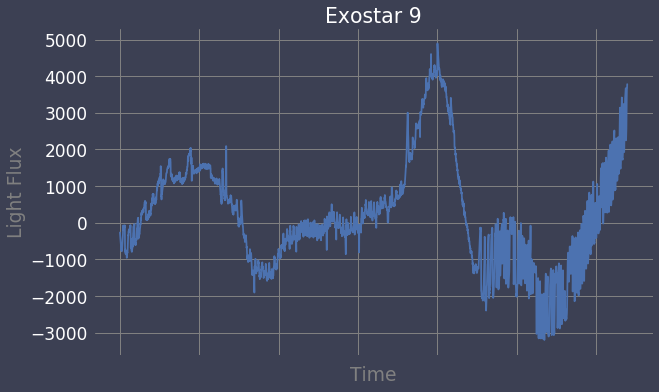

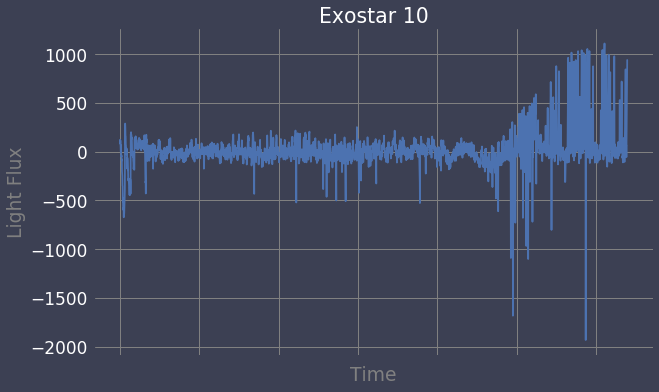

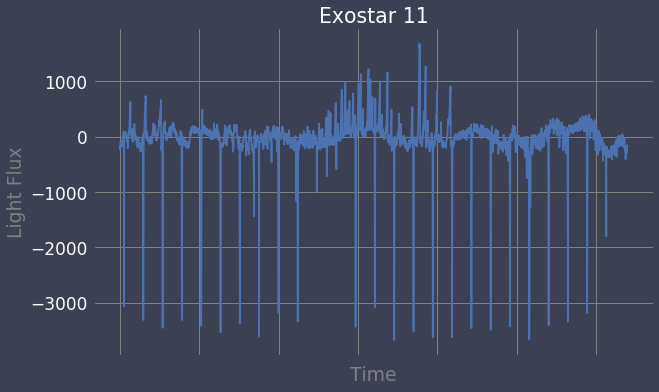

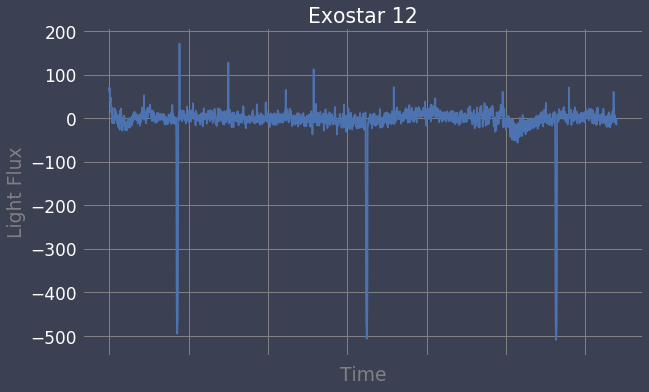

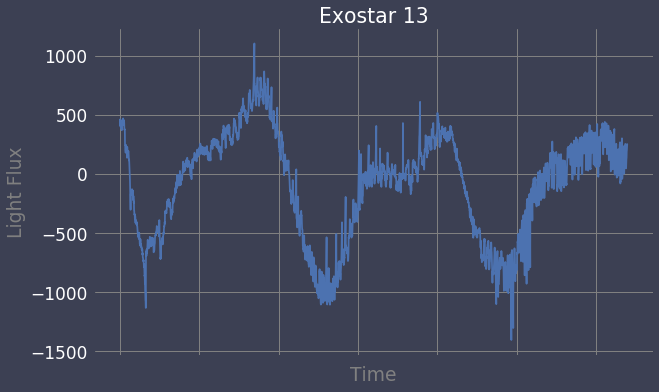

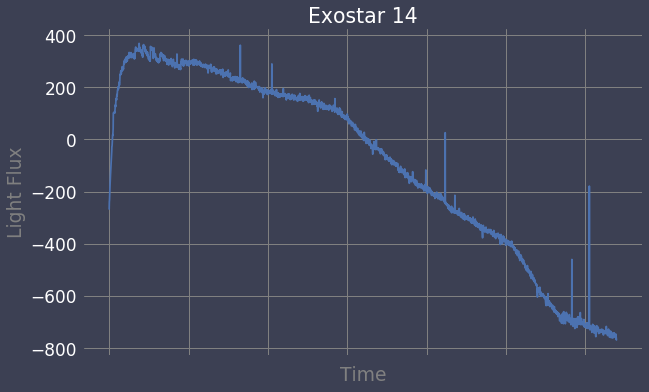

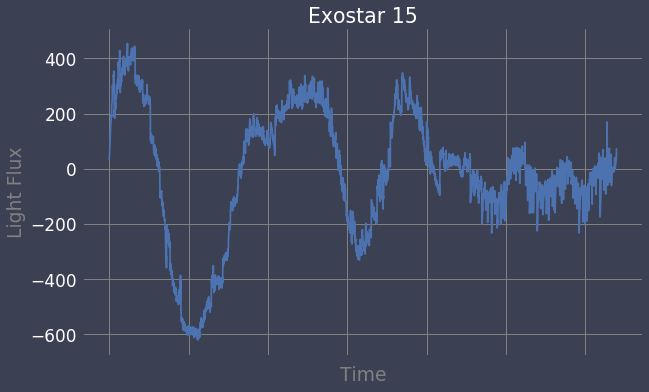

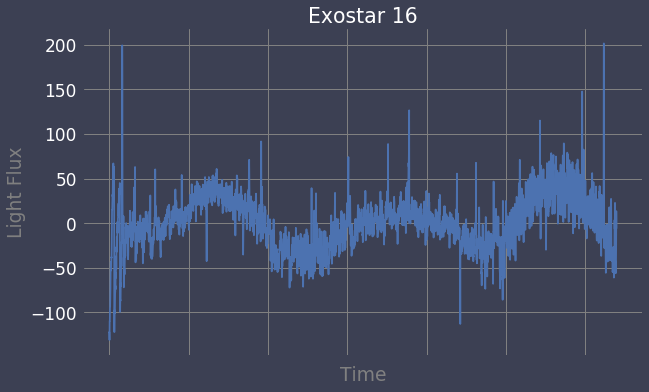

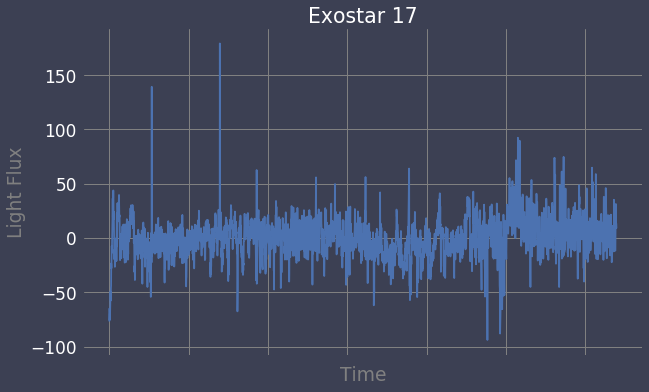

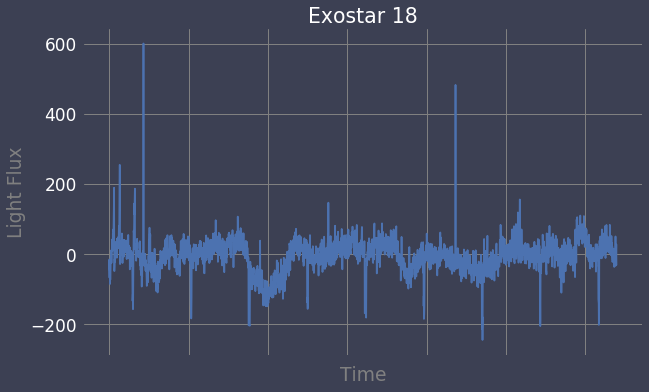

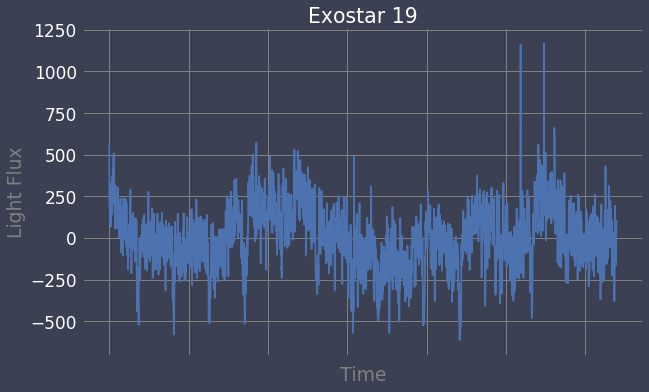

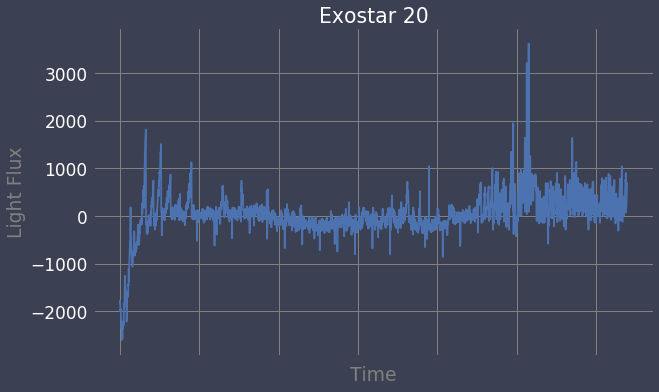

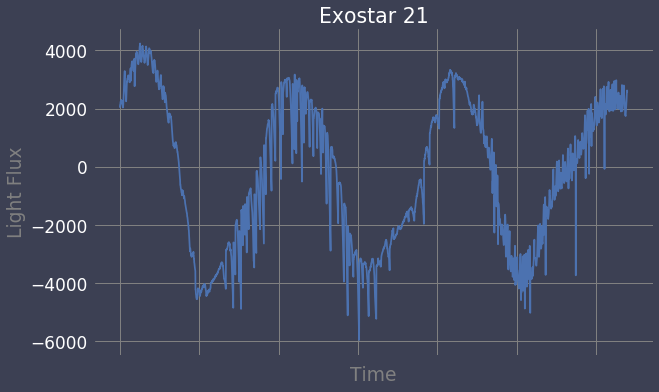

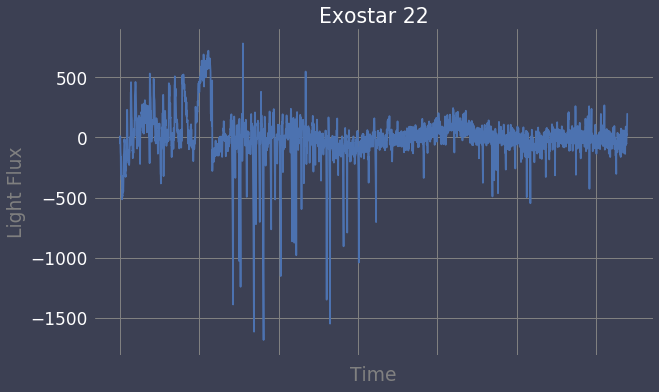

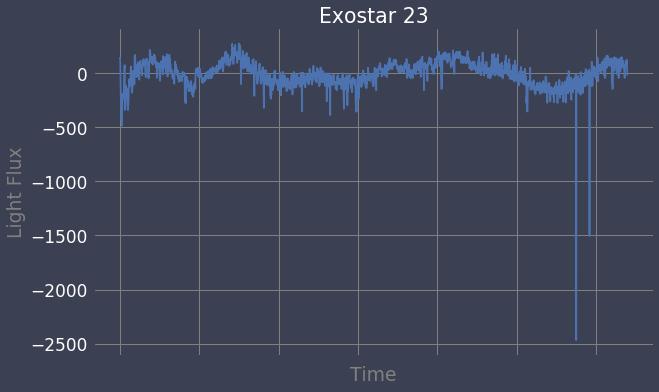

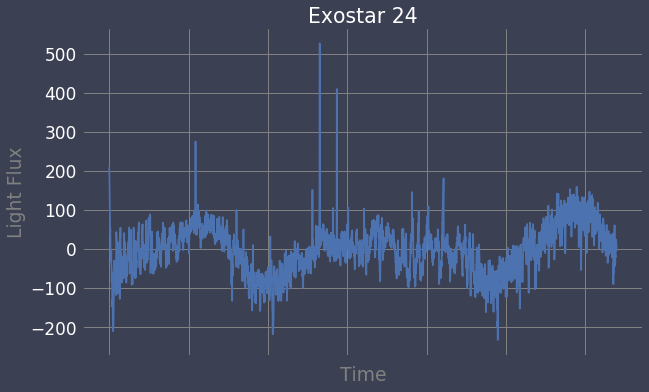

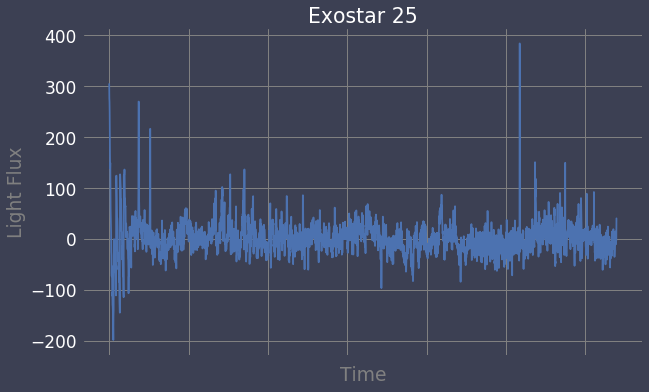

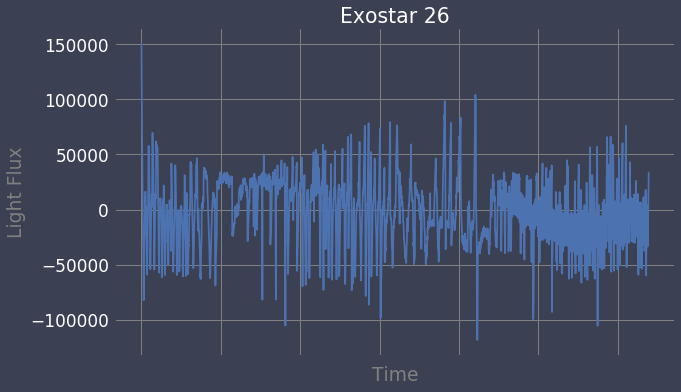

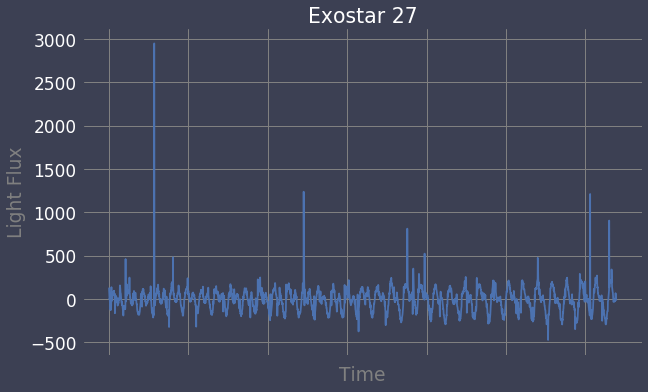

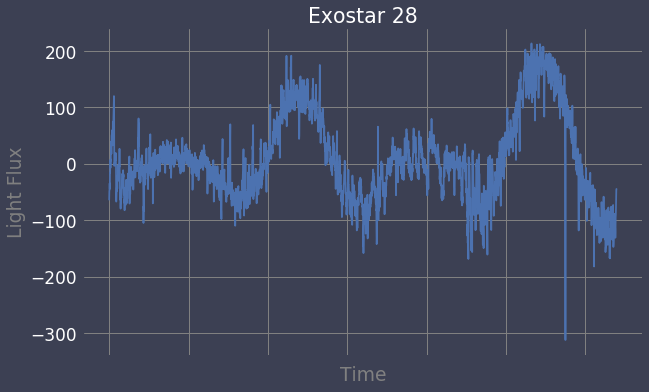

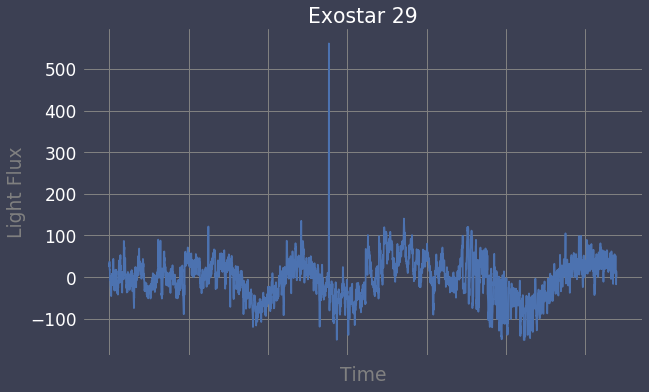

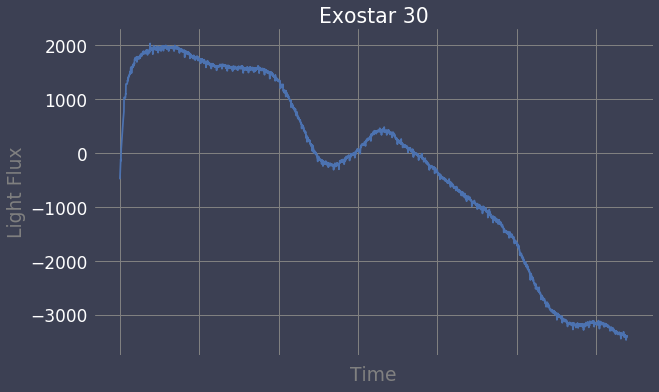

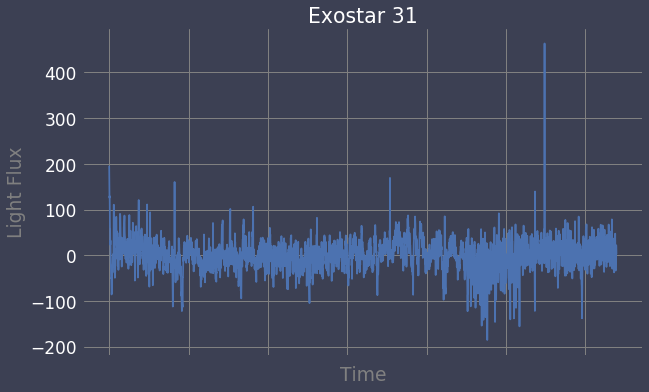

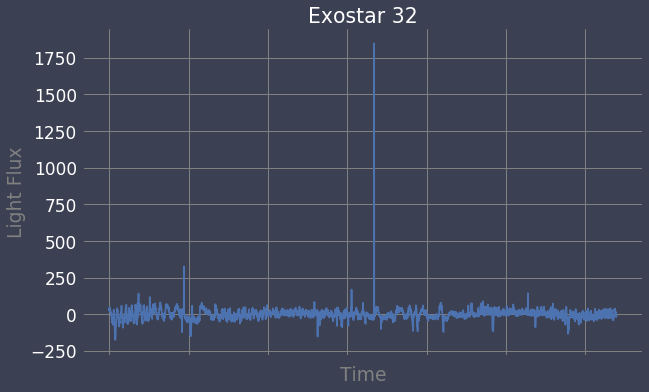

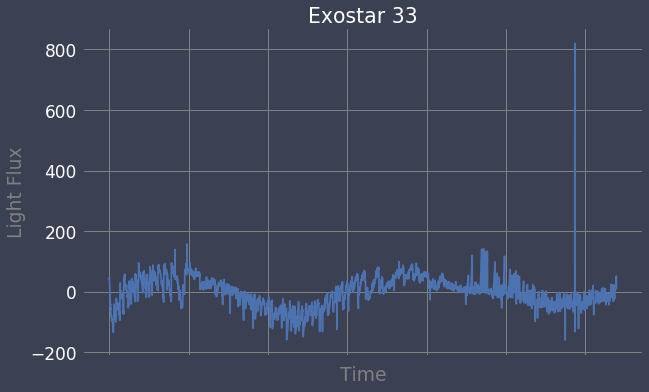

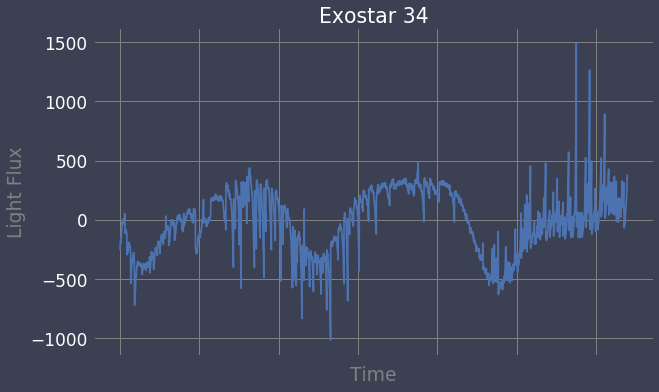

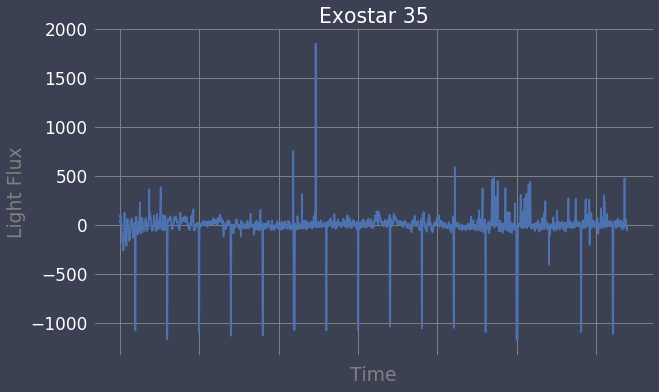

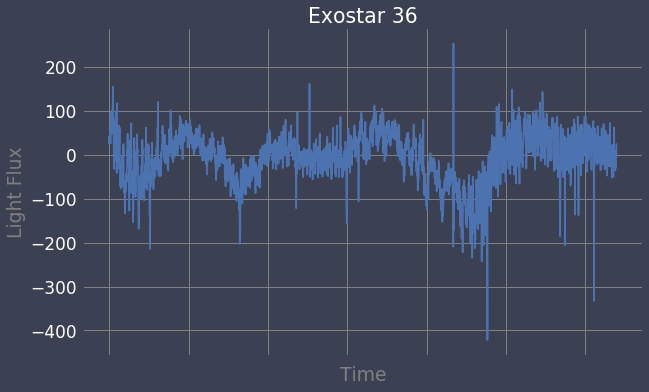

In [18]:
for i in range(exo1.shape[0]):
    exo1.iloc[i].plot(figsize=[10,6], title='Exostar {}'.format(i))
    plt.xlabel('Time')
    plt.ylabel('Light Flux')
    plt.show()

Noisy data. Some plots follow a wave pattern. This is unusally. Was expecting plots like "Exoplanet 7". Looking to smooth the data and remove the wave pattern to prod